# Code to plot and observe the raw data

Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
import plotly.express as px

Define functions

In [2]:
def get_indices_in_range(lst, start, end):
    """
    Returns a new list containing only the indices of the values within the given range (inclusive).
    """
    return [i for i, x in enumerate(lst) if start <= x <= end]

def remove_indexes(my_list, indexes_to_remove):
    return [x for i, x in enumerate(my_list) if i not in indexes_to_remove]

def read_dat_file(filename,skip):
    data = np.loadtxt(filename+'.dat',skiprows= skip,encoding='unicode_escape') #utf-8-sig')
    col = []
    num = len(data.transpose())
    for i in range(num):
        if num == len(data):
            col1 = data[i]
        else:
            col1 = data[:,i]
        col.append(col1)

    return col

def gaussian(x, a, x0, sigma):
    """
    Gaussian function with amplitude a, mean x0, and standard deviation sigma.
    """
    return a * np.exp(-(x - x0)**2/ (2 * sigma**2))


def gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        amp, cen, wid = params[i:i+3]
        y = y + amp * np.exp(-(x-cen)**2 / (2*wid**2))
    return y


def asymmetric_gaussian(x, I0, x0, w1, w2):
    #global yl 
    #global yr
    return 1/2*I0*(1-np.sign(x-x0))*np.exp(-(x - x0)**2/ (2 * w1**2)) + 1/2*I0*(1-np.sign(x0-x))*np.exp(-(x - x0)**2/ (2 * w2**2))# +1/2*yl*(1-np.sign(x-x0)) + 1/2*yr*(1-np.sign(x0-x))


def asymmetric_gaussian_sum(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 4):
        I0, x0, w1, w2 = params[i:i+4]
        y = y + 1/2*I0*(1-np.sign(x-x0))*np.exp(-(x - x0)**2/ (2 * w1**2)) + 1/2*I0*(1-np.sign(x0-x))*np.exp(-(x - x0)**2/ (2 * w2**2)) #+1/2*yl*(1-np.sign(x-x0)) + 1/2*yr*(1-np.sign(x0-x))
    return y

def my_round(x,dx):      # per avere dato + errore con le giuste cire significative (incertezza con una sola cifra significativa)  ---> da sistemare,quando dx salta di cifra x resta arrotondato a cifra sotto
    round_x = []
    if np.size(x) > 1:
        for i in range(np.size(x)):
            if dx[i] < 1:
                dist = -int(np.log10(dx[i])-1)
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx[i]))
                dx_new =  round(dx[i],dist)
                x_new = round(x[i],-int(np.log10(dx_new)))
            round_x.append([x_new,dx_new])
    else:
            if dx < 1:
                dist = -int(np.log10(dx)-1)
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)-1))
            else:
                dist = -int(np.log10(dx))
                dx_new =  round(dx,dist)
                x_new = round(x,-int(np.log10(dx_new)))
            round_x.append([x_new, dx_new])
    return round_x

# Detector parameters

channels = read_dat_file('efficiency',3)[0] # canali del detector
angle_range = 128   # range angolare del detector
lamda = 0.729 # Angstrom inversi


def steps_to_angle(steps):
    angle = steps*angle_range/np.size(channels)    # max angle / n of channels
    return angle

def steps_to_q(steps):
    angle = steps*angle_range/np.size(channels) 
    q = 4*np.pi*np.sin(angle*np.pi/360)/lamda   # in Angstrom inversi
    return q

#Define scattering angle 2theta and exchanged wavewector q
angle = steps_to_angle(channels)
q = steps_to_q(channels)

In [3]:
# function to plot data

def plot_raw_data(file0,num_files, title):
    efficiency = read_dat_file('efficiency',3)[1]
    filename = []

    for i in range (num_files):
        num = int(file0) + i
        num = str(num)
        filename.append('bs'+num)

    data = []
    err_data = []

    for i in range (num_files):
        name = filename[i]
        data.append(read_dat_file(name,3)[1]/efficiency)
        err_data.append(read_dat_file(name,3)[2]/efficiency)
        plt.errorbar(channels,data[i], fmt = '-', yerr = err_data[i] ,label = name)
    plt.xlabel('Channel')
    plt.ylabel('Intensity  [counts]')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()
    return data, err_data


# Efficiency

efficiency    

Efficiency of channels: divide by it to smooth data

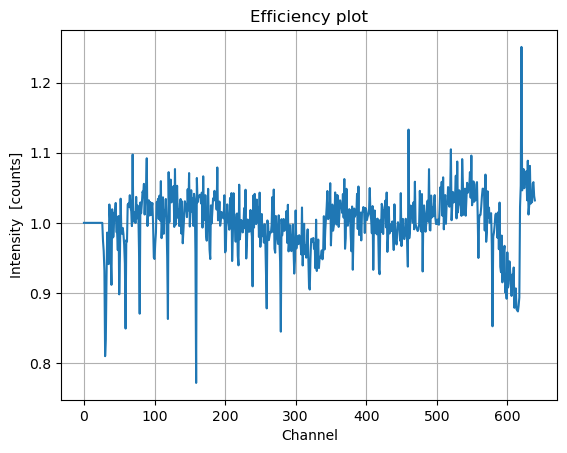

In [4]:
efficiency = read_dat_file('efficiency',3)[1]
err_efficiency = read_dat_file('efficiency',3)[2]
plt.plot(channels,efficiency, '-')
plt.xlabel('Channel')
plt.ylabel('Intensity  [counts]')
plt.title('Efficiency plot')
plt.grid()
plt.show()

# NICKEL POWDER : Calibration $2 \theta$ vs. channel

Use Ni reflections to calibrate the scattering angle in function of the channel. One retrieves the peaks position in the Ni powder diffraction pattern and fits them to the Bragg law  
$$
\lambda = 2 d_{hkl}\sin(\theta)
$$

with $\lambda$ the neutron waveelngth selected at the monocromator, $d_{hkl}$ the d-spacing of planes (hkl) and $\theta$ is half the scattering angle, or the Bragg angle. This angle is associated to the correspondent channel in the detector by the linear relation

$$
\theta = \theta_0 + \Delta \theta channel
$$

and the angular step $\delta \theta$ is known to be $0.2^{\circ}$, since there are 640 channels covering an angular range of $128^{\circ}$.  
Then one finds the allowed reflections for the Ni powder (hkl), associate them with the observed peaks in the pattern and retrieves the corresponding d-spacing $d_{hkl}$ as 
$$
\frac{1}{d_{hkl}} = \frac{\sqrt{h^2+k^2+l^2}}{a}
$$

with $a = 3.524 \AA$ the lattice parameter at 293 K (from "High-temperature thermal expansion of six metallic elements measured by dilatation method and X-ray diffraction Sample: at T = 1433 K").  

Then the retrieved peaks position are fitted to the inverse of the Bragg law
$$
channel = \left(\arcsin\left(\frac{\lambda}{2 d_{hkl}}\right)-\theta_0\right)/\Delta \theta
$$
with $\Delta \theta = 0.2 \times\frac{\pi}{360}$ rad.  

To gain resolution and fit better the peaks 4 repetitions were done and in eaach one the detector was rotated 1/4 of step, in order to increase the number of data.  

bs44380	M=200000   
bs44381	M=200000 con detector ruotato di 0.05°  
bs44382	M=200000 con detector ruotato di 0.10°  
bs44383	M=200000 con detector ruotato di 0.14° 

Moreover, background subtraction is required to fit well the peaks position (up to now linear fit, better considering TDS), maybe also need to consider diffraction form cell containing the powder and/or data treatment of Petrillo and Sacchetti.


Import data of four repetitions

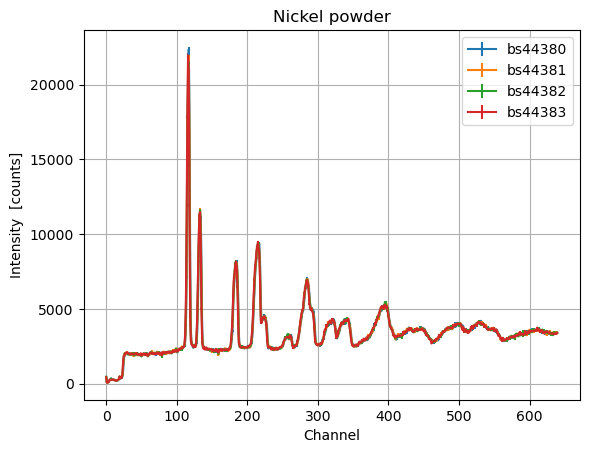

In [5]:
nickelone, err_nickelone = plot_raw_data('44380',4, 'Nickel powder')



Merge the four set of data by considering fractions of channel

In [6]:
step = np.zeros(4*np.size(channels))
nickel_back= np.zeros(4*np.size(channels))
err_nickel_back = np.zeros(4*np.size(channels))


for i in range(np.size(channels)):
    step[4*i] = i 
    step[4*i+1] = i + 0.25
    step[4*i+2] = i + 0.5
    step[4*i+3] = i + 0.14/0.2

    nickel_back[4*i] = nickelone[0][i]
    nickel_back[4*i+1] = nickelone[1][i]
    nickel_back[4*i+2] = nickelone[2][i]
    nickel_back[4*i+3] = nickelone[3][i]

    err_nickel_back[4*i] = err_nickelone[0][i]
    err_nickel_back[4*i+1] = err_nickelone[1][i]
    err_nickel_back[4*i+2] = err_nickelone[2][i]
    err_nickel_back[4*i+3] = err_nickelone[3][i]

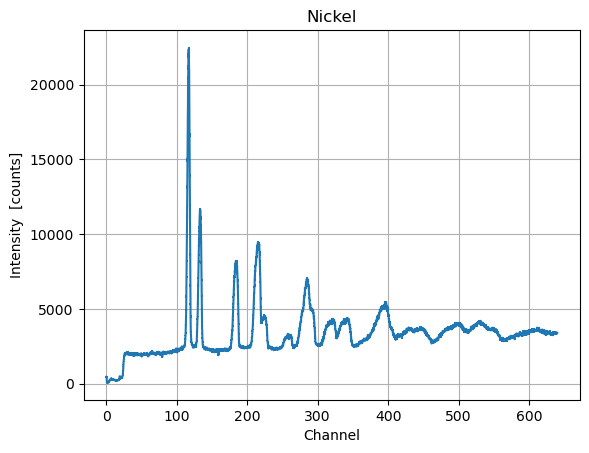

In [7]:
#%matplotlib ipympl
plt.errorbar(step,nickel_back, fmt = '-', yerr = err_nickel_back)
plt.xlabel('Channel')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel')
plt.grid()
plt.show()

Background subtraction: linear fit to data outside peaks, probably better to fit the whole profile considering the presence of constant background + TDS (see Suppplementary info to Real time Observation...). Problem: for TDS need already to know calibration.

Fit parameters
Intercept 1897.0 +/- 5.0 counts
Slope 2.06 +/- 0.03 counts/step


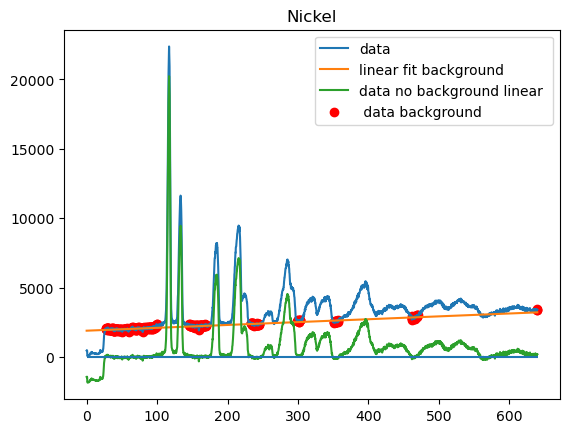

In [8]:
#background subtraction

#%matplotlib ipympl

def lin_fit(x,a,b):
    return a*x + b



indici = get_indices_in_range(step,0,27)
x_data_fondo = remove_indexes(list(step),indici)
y_data_fondo = remove_indexes(list(nickel_back),indici)

indici = get_indices_in_range(x_data_fondo,100,145)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,170,233)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,245,299)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,303,351)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,357,461)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,470,639)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

'''plt.plot(step,nickel_back[0],label="data")    
plt.scatter(x_data_fondo,y_data_fondo,label="background",color="red")   
plt.title("Nickel background")
plt.legend()
plt.show() '''
popt,pcov = curve_fit(lin_fit,x_data_fondo,y_data_fondo,sigma = np.sqrt(y_data_fondo))
par = my_round(popt,np.sqrt(np.diag(pcov)))
print('Fit parameters')
print('Intercept',par[1][0], '+/-', par[1][1],'counts')
print('Slope',par[0][0], '+/-', par[0][1],'counts/step')

plt.plot(step,nickel_back,label="data")
plt.plot(step,lin_fit(step,*popt),label="linear fit background")
plt.plot(step,nickel_back-lin_fit(step,*popt),label="data no background linear ")
plt.scatter(x_data_fondo,y_data_fondo,label=" data background",color="red")  
plt.hlines(0,0,640)
plt.title("Nickel")
plt.legend()
plt.show()

nickel = nickel_back - lin_fit(step, *popt)
err_nickel = np.sqrt(err_nickel_back**2 + pcov[0][0] + pcov[1][1])

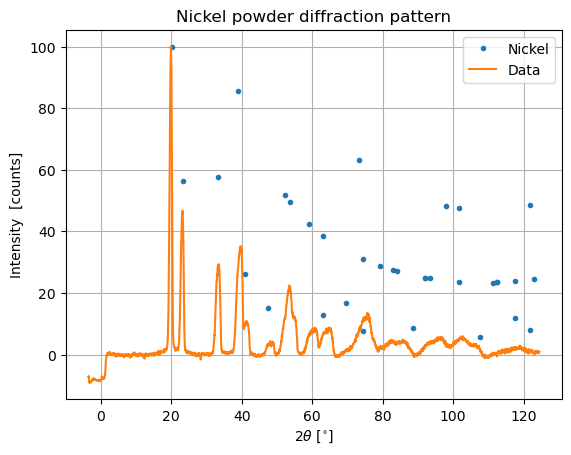

In [9]:
#Compare with diffraction pattern from VESTA
#%matplotlib ipympl
twotheta = read_dat_file('nickel_vesta',1)[7]
intensity = read_dat_file('nickel_vesta',1)[8]

twotheta_v = read_dat_file('vanadium_vesta',1)[7]
intensity_v = read_dat_file('vanadium_vesta',1)[8]

twotheta_al = read_dat_file('aluminum_vesta',1)[7]
intensity_al = read_dat_file('aluminum_vesta',1)[8]

plt.plot(twotheta,intensity,'.',label = 'Nickel')
#plt.plot(twotheta_v,intensity_v,'v',label = 'Vanadium')
#plt.plot(twotheta_al,intensity_al,'x',label = 'Aluminum')
plt.plot(steps_to_angle(step)-3.5,nickel*100/max(nickel),label = 'Data')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel powder diffraction pattern')
plt.legend()
plt.grid()
plt.show()

Function to fit a certain peak with a custom number of gaussians, need to give p0 as input return fit parameters and their errors.

In [10]:
def fit_peak(x,data, err_data, p0):

    bounds = []
    bounds.append(np.zeros(np.size(p0)))
    bounds.append(np.ones(np.size(p0))*np.inf)

    popt, pcov = curve_fit(gaussian_sum,x, data,sigma=err_data,p0=p0, bounds = bounds, maxfev = 80000)
    chi_sq = sum((gaussian_sum(x,*popt)-data)**2/err_data**2)/(len(data)-len(p0))
    par = my_round(popt,np.sqrt(np.diag(pcov)))

    for i in range(np.size(p0)//3):
        print('### Gaussian %d ####' % i)
        print('Peak position',par[3*i+1][0], '+/-', par[3*i+1][1],'channel')
        print('Peak height',par[3*i][0], '+/-', par[3*i][1],'counts')
        print('Peak width',par[3*i+2][0], '+/-', par[3*i+2][1],'channel')
    print('Chi squared / dof', chi_sq)
    x_plot = np.linspace(min(x), max(x),10000)
    plt.plot(x_plot, gaussian_sum(x_plot, *popt),color='red',label = 'Fit to %8.0f gaussians' %(len(p0)//3))

    for i in range(len(p0)//3):
        plt.plot(x_plot,gaussian(x_plot, *popt[3*i:3*i+3]),label = 'Gaussian %d' % (i+1))

    plt.errorbar(x,data, yerr=err_data, fmt = '.',label='Data')
    plt.xlabel('Channel')
    plt.ylabel('Intensity [counts]')
    plt.legend()
    plt.grid()
    plt.show()

    return popt, np.sqrt(np.diag(pcov))


Picco 0

Peak position 116.7 +/- 0.03 channel
Peak height 20400.0 +/- 400.0 counts
Peak width -1.57 +/- 0.02 channel
Chi squared / dof 73.2579444350394


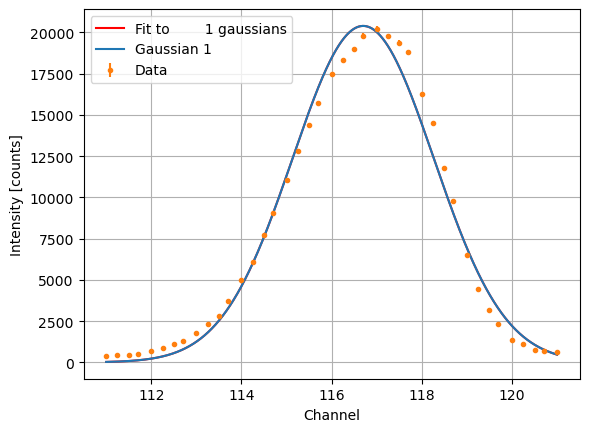

In [11]:
index = get_indices_in_range(step, 111, 121)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]
x_plot = np.linspace(min(x), max(x),10000)

#p0 = [7000,115, 7,7000,117,5]
p0 = [7000,115, 7]
bounds = [[-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]]
popt, pcov = curve_fit(gaussian_sum,x, data,sigma=err_data,p0=p0, bounds = bounds, maxfev = 80000)
chi_sq = sum((gaussian_sum(x,*popt)-data)**2/err_data**2)/(len(data)-len(p0))

par = my_round(popt,np.sqrt(np.diag(pcov)))
print('Peak position',par[1][0], '+/-', par[1][1],'channel')
print('Peak height',par[0][0], '+/-', par[0][1],'counts')
print('Peak width',par[2][0], '+/-', par[2][1],'channel')
#print('Peak position',par[4][0], '+/-', par[4][1],'channel')
#print('Peak height',par[3][0], '+/-', par[3][1],'counts')
#print('Peak width',par[5][0], '+/-', par[5][1],'channel')
print('Chi squared / dof', chi_sq)

plt.plot(x_plot, gaussian_sum(x_plot, *popt),color='red',label = 'Fit to %8.0f gaussians' % (len(p0)//3))
for i in range(len(p0)//3):
    plt.plot(x_plot,gaussian(x_plot, *popt[3*i:3*i+3]),label = 'Gaussian %d' % (i+1))

plt.errorbar(x,data, yerr=err_data, fmt = '.',label='Data')
plt.xlabel('Channel')
plt.ylabel('Intensity [counts]')
plt.legend()
plt.grid()
plt.show()

nickel_parameters = abs(popt)
err_nickel_parameters = np.sqrt(np.diag(pcov))

Picco 1

### Gaussian 0 ####
Peak position 132.88 +/- 0.04 channel
Peak height 9700.0 +/- 200.0 counts
Peak width 1.86 +/- 0.04 channel
Chi squared / dof 43.620946531941605


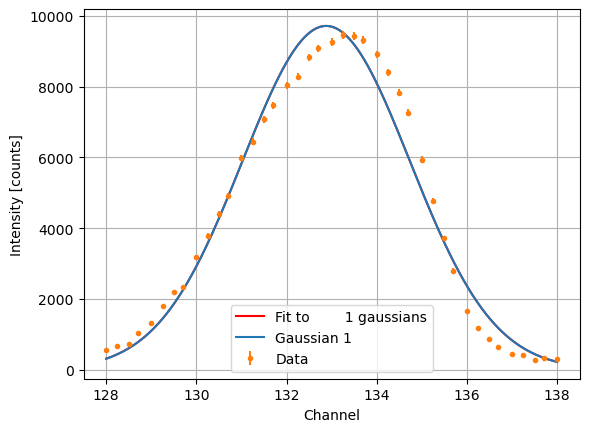

In [12]:
index = get_indices_in_range(step, 128, 138) 
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

#p0 = [2000,132, 2,8000,133,2]
p0 = [2000,132, 2]


par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 2

### Gaussian 0 ####
Peak position 183.68 +/- 0.07 channel
Peak height 6300.0 +/- 200.0 counts
Peak width 2.7 +/- 0.07 channel
Chi squared / dof 51.028133926519025


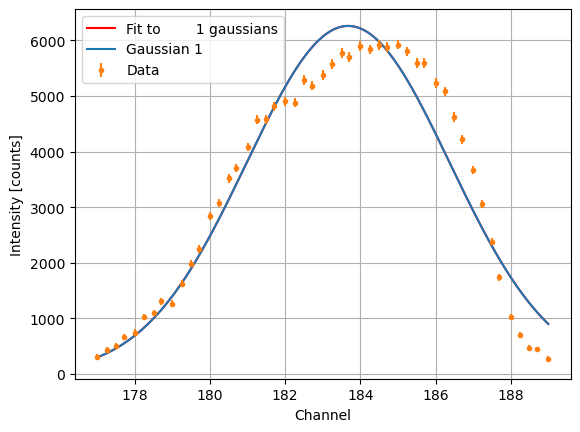

In [13]:
index = get_indices_in_range(step, 177, 189)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

#p0 = [3500,182, 2,5000,185,2]
p0 = [3500,182, 2]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 3 and 4

### Gaussian 0 ####
Peak position 214.57 +/- 0.07 channel
Peak height 7300.0 +/- 100.0 counts
Peak width 3.75 +/- 0.07 channel
### Gaussian 1 ####
Peak position 225.33 +/- 0.1 channel
Peak height 2200.0 +/- 100.0 counts
Peak width 2.19 +/- 0.1 channel
Chi squared / dof 29.464102938233683


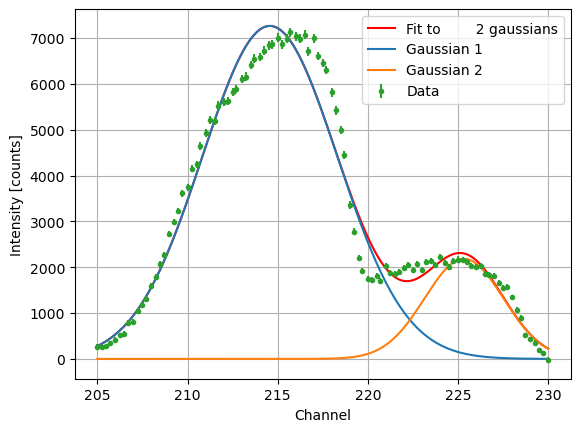

In [14]:
index = get_indices_in_range(step, 205, 230)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

#p0 = [2000,212,2,5000,216, 5,2000,223,5]
p0 = [2000,212,2,2000,223,5]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 5

### Gaussian 0 ####
Peak position 258.2 +/- 0.2 channel
Peak height 780.0 +/- 30.0 counts
Peak width 4.8 +/- 0.2 channel
Chi squared / dof 4.908097474662657


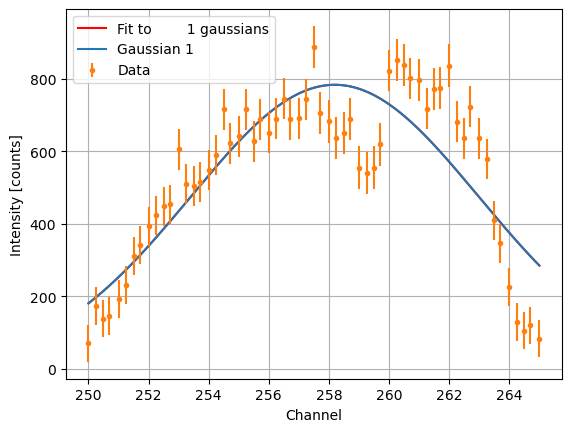

In [15]:
index = get_indices_in_range(step, 250, 265)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

#p0 = [700,255, 6,800,262,4]
p0 = [700,255, 6]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 6 and 7

### Gaussian 0 ####
Peak position 284.35 +/- 0.08 channel
Peak height 4200.0 +/- 40.0 counts
Peak width 5.82 +/- 0.08 channel
### Gaussian 1 ####
Peak position 293.7 +/- 0.1 channel
Peak height 1210.0 +/- 80.0 counts
Peak width 1.44 +/- 0.1 channel
Chi squared / dof 7.122361282839428


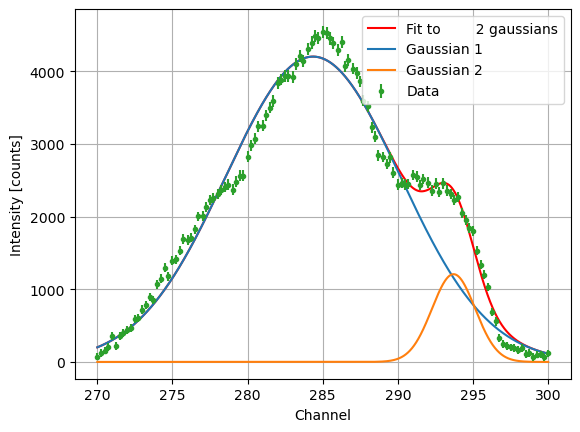

In [16]:
index = get_indices_in_range(step, 270, 300)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

#p0 = [1000,277,5,4500,285, 5,2500,292,2]
p0 = [4500,285, 5,2500,292,2]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 8 and 9

### Gaussian 0 ####
Peak position 318.3 +/- 0.2 channel
Peak height 1710.0 +/- 40.0 counts
Peak width 6.5 +/- 0.2 channel
### Gaussian 1 ####
Peak position 339.2 +/- 0.2 channel
Peak height 1820.0 +/- 40.0 counts
Peak width 5.6 +/- 0.2 channel
Chi squared / dof 10.87819232599246


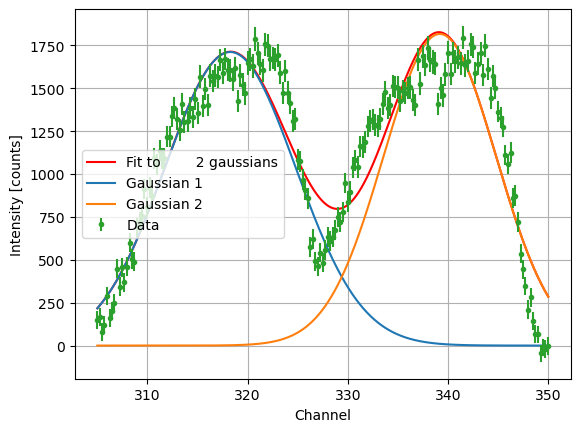

In [17]:
index = get_indices_in_range(step, 305, 350)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [1750,317,15,1750,340,15]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 10 and 11
From here there are amny allowe reflections for peak, then one could possibly fi tthe peaks with more gaussians --> overfitting is a serious risk

### Gaussian 0 ####
Peak position 390.9 +/- 0.2 channel
Peak height 1980.0 +/- 50.0 counts
Peak width 10.46 +/- 0.1 channel
### Gaussian 1 ####
Peak position 396.5 +/- 0.2 channel
Peak height 800.0 +/- 50.0 counts
Peak width 4.2 +/- 0.3 channel
Chi squared / dof 2.3034067358562207


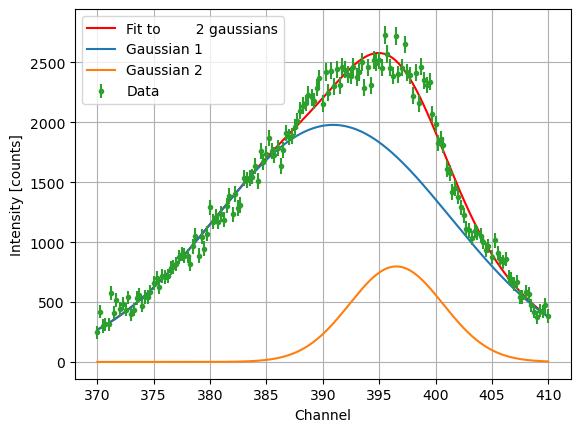

In [18]:
index = get_indices_in_range(step, 370, 410)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [900,380, 10,900,400,10]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 12 and 13

### Gaussian 0 ####
Peak position 432.3 +/- 0.7 channel
Peak height 820.0 +/- 10.0 counts
Peak width 14.7 +/- 0.6 channel
### Gaussian 1 ####
Peak position 449.0 +/- 0.2 channel
Peak height 420.0 +/- 40.0 counts
Peak width 4.7 +/- 0.5 channel
Chi squared / dof 1.5095379064139736


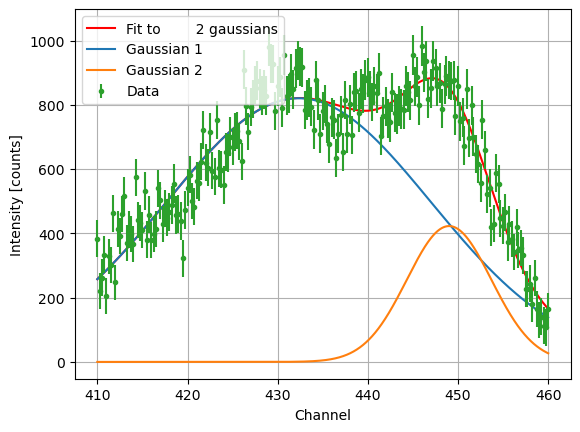

In [19]:
index = get_indices_in_range(step, 410, 460)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [900,430, 10,900,450,10]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 14, 15, 16 and 17

### Gaussian 0 ####
Peak position 483.5 +/- 0.7 channel
Peak height 740.0 +/- 20.0 counts
Peak width 7.6 +/- 0.5 channel
### Gaussian 1 ####
Peak position 499.7 +/- 0.4 channel
Peak height 970.0 +/- 40.0 counts
Peak width 6.6 +/- 0.3 channel
### Gaussian 2 ####
Peak position 529.2 +/- 0.2 channel
Peak height 1080.0 +/- 10.0 counts
Peak width 11.8 +/- 0.3 channel
### Gaussian 3 ####
Peak position 550.9 +/- 0.2 channel
Peak height 410.0 +/- 20.0 counts
Peak width 4.4 +/- 0.3 channel
Chi squared / dof 1.08430080386257


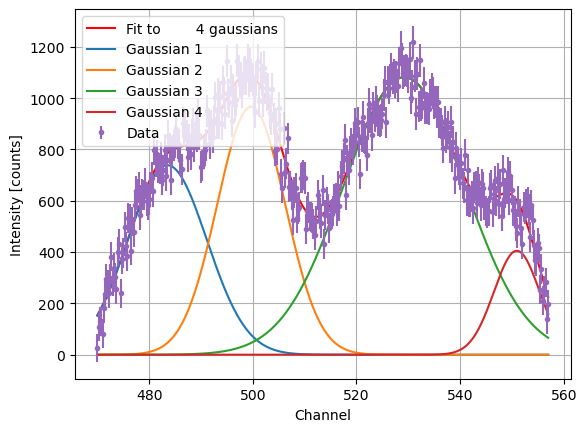

In [20]:
index = get_indices_in_range(step, 470, 557)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]

p0 = [800,490,5,1100,500, 5,1100,530,5, 800,550,5]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Peak 18

### Gaussian 0 ####
Peak position 609.1 +/- 0.4 channel
Peak height 400.0 +/- 8.0 counts
Peak width 17.7 +/- 0.5 channel
Chi squared / dof 1.394241198312346


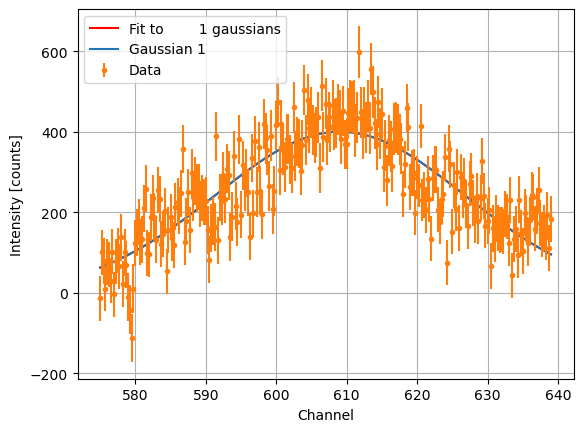

In [21]:
index = get_indices_in_range(step, 575, 639)
x = step[index]
data = nickel[index]
err_data = err_nickel[index]


p0 = [900,600, 10,]

par, err_par = fit_peak(x,data,err_data,p0)

nickel_parameters = np.append(nickel_parameters,par)
err_nickel_parameters= np.append(err_nickel_parameters,err_par)

Plot the fit for the whole pattern

[2.03967110e+04 1.16698993e+02 1.56587767e+00 9.71818267e+03
 1.32878554e+02 1.85670958e+00 6.26136760e+03 1.83675139e+02
 2.70298654e+00 7.26200986e+03 2.14566661e+02 3.74997540e+00
 2.18211842e+03 2.25331223e+02 2.18505951e+00 7.82933030e+02
 2.58194843e+02 4.78814632e+00 4.20183511e+03 2.84351679e+02
 5.81857318e+00 1.20750177e+03 2.93702331e+02 1.43619950e+00
 1.71151796e+03 3.18268458e+02 6.52850906e+00 1.81656541e+03
 3.39177848e+02 5.62522258e+00 1.97906290e+03 3.90912383e+02
 1.04634939e+01 7.97339219e+02 3.96521060e+02 4.15028768e+00
 8.20547409e+02 4.32324900e+02 1.46641917e+01 4.22795910e+02
 4.49008691e+02 4.67900096e+00 7.38747986e+02 4.83515198e+02
 7.61450111e+00 9.66690676e+02 4.99693854e+02 6.55913076e+00
 1.08160178e+03 5.29207357e+02 1.17511292e+01 4.05069258e+02
 5.50943033e+02 4.41988104e+00 4.00221631e+02 6.09060600e+02
 1.76806635e+01]


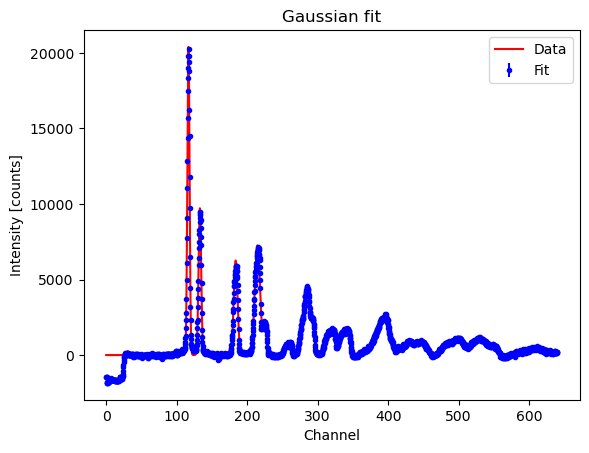

In [22]:
#%matplotlib ipympl
x_plot = np.linspace(min(step), max(step),10000)
print(nickel_parameters)

plt.errorbar(step,nickel,yerr = err_nickel,fmt='.',color='blue')
plt.plot(x_plot, gaussian_sum(x_plot, *nickel_parameters),color='red')
plt.title('Gaussian fit')
plt.legend(['Data','Fit'])
plt.xlabel('Channel')
plt.ylabel('Intensity [counts]')
plt.show()

In [23]:
nickel_peaks = []
err_nickel_peaks = []
width_nickel_peaks = []
err_width_nickel_peaks = []
height_nickel_peaks = []
err_height_nickel_peaks = []

for i in range (len(nickel_parameters)//3):
    nickel_peaks.append(nickel_parameters[3*i+1])
    err_nickel_peaks.append(err_nickel_parameters[3*i+1])
    width_nickel_peaks.append(nickel_parameters[3*i+2])
    err_width_nickel_peaks.append(err_nickel_parameters[3*i+2])
    height_nickel_peaks.append(nickel_parameters[3*i])
    err_height_nickel_peaks.append(err_nickel_parameters[3*i])


print(nickel_peaks,err_nickel_peaks)
print(width_nickel_peaks,err_width_nickel_peaks)
print(height_nickel_peaks,err_height_nickel_peaks)

[116.69899284380257, 132.87855429895782, 183.6751387023374, 214.5666614163248, 225.331223305237, 258.1948431810115, 284.3516785969082, 293.70233108627644, 318.26845766253035, 339.1778478387965, 390.91238252965366, 396.5210603490339, 432.3249001369896, 449.00869146122614, 483.5151975277706, 499.693854322345, 529.2073571237186, 550.9430325843338, 609.0605998061299] [0.029546180702506607, 0.039997437393164276, 0.0740662708107027, 0.06708675203853287, 0.1434522682197624, 0.20031164230155546, 0.08298091874340612, 0.0986004402189612, 0.1958847858939935, 0.176139039701171, 0.19592024938681044, 0.19945653616324016, 0.6810436413110428, 0.2261051160208091, 0.6647778472896392, 0.39720249430429266, 0.1698077064417272, 0.2159697619788301, 0.4035574087011853]
[1.5658776709995685, 1.8567095784651924, 2.7029865439346037, 3.7499754032793344, 2.185059514770521, 4.7881463172898675, 5.818573181022037, 1.4361995045721496, 6.5285090572268025, 5.625222584846948, 10.463493869276205, 4.150287681809707, 14.6641

Index peaks and average fit values between repetitions

In [24]:
#Fit peaks position to Bragg law

# lattice parameters
a = 3.524 # Angstrom   at 293 K from "High-temperature thermal expansion of six metallic elements measured by dilatation method and X-ray diffraction Sample: at T = 1433 K"

# allowed reflections
h = np.array([1,2,2,3,2,4,3,4,4,5,4,4,6,6,4,6,6,7,8,7])
k = np.array([1,0,2,1,2,0,3,2,2,1,4,4,2,2,4,4,4,3,0,5])
l = np.array([1,0,0,1,2,0,1,0,2,1,0,2,0,2,4,0,2,1,0,1])

d_inv = np.sqrt((h**2+k**2+l**2)/a**2)
x = np.arcsin(0.729*d_inv/2)



Fit to bragg law, both with three free parameters ($\lambda, \theta_0$ and $\Delta \theta$) and two free parameters, fix $\Delta \theta = 0.2^{\circ}$

 #### Fit to Bragg law ####
lambda 0.738 +/- 0.003 Angstrom
theta0 -2.4064227395494577 +/- 0.11459155902616464 deg
Chi squared/ dof 164.95098325622553


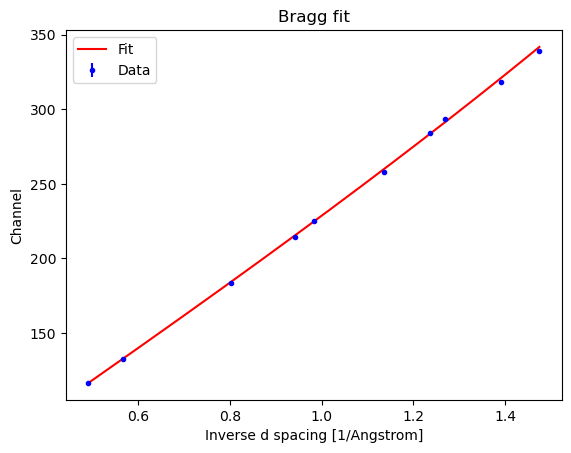

In [25]:
#Fix delta theta = 0.2 deg
#%matplotlib ipympl
nickel_peaks_new = np.array(nickel_peaks[0:10])
err_nickel_peaks_new = np.array(err_nickel_peaks[0:10])

def bragg_fix(d_inv,lmbd,theta0):
    pippo = np.arcsin(lmbd*d_inv/2)
    return (pippo-theta0)/(0.2*np.pi/360)

p0 = [0.72,-3*np.pi/360]
bounds = ([0.1,-np.inf],[1,np.inf])
popt, pcov = curve_fit(bragg_fix, d_inv[0:10], nickel_peaks_new[0:10], sigma = err_nickel_peaks_new[0:10],bounds = bounds, maxfev=800000) 


chi_sq = sum((bragg_fix(d_inv[0:10],*popt)-nickel_peaks_new[:])**2/err_nickel_peaks_new[:]**2)/(np.size(nickel_peaks_new[:])-2)

lamda = popt[0]
err_lamda = np.sqrt(pcov[0][0])

theta0 = popt[1]*360/np.pi
err_theta0 = np.sqrt(pcov[1][1])*360/np.pi

print(' #### Fit to Bragg law ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))

print('lambda',par[0][0], '+/-', par[0][1],'Angstrom')
print('theta0',par[1][0]*360/np.pi, '+/-', par[1][1]*360/np.pi,'deg')

print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(d_inv), max(d_inv[0:10]),10000)
plt.plot(x_plot, bragg_fix(x_plot, *popt),color='red')
plt.errorbar(d_inv[0:10],nickel_peaks_new[:], yerr=err_nickel_peaks_new[:],fmt='.',color='blue')
plt.title('Bragg fit')
plt.legend(['Fit', 'Data'])
plt.ylabel('Channel')
plt.xlabel('Inverse d spacing [1/Angstrom]')
plt.show()



 #### Fit to Bragg law ####
Slope 583.0 +/- 3.0 channel
Intercept 11.5 +/- 0.7 channel
#####
dtheta 0.19659845941955842 +/- 0.004393292888102416 deg
theta0 -2.260566225901783 +/- 0.13336388516745903 deg
Chi squared/ dof 164.95098325622553


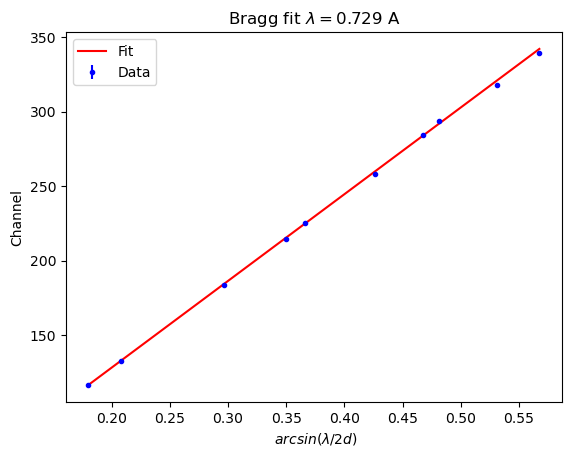

In [26]:
#linear fit to arcsin (fix lambda)


bounds = [[-np.inf,-np.inf],[np.inf,np.inf]]
popt, pcov = curve_fit(lin_fit, x[0:8], nickel_peaks_new[0:8], sigma =err_nickel_peaks_new[0:8],bounds = bounds, maxfev = 80000)

#chi_sq = sum((lin_fit(x[0:7],*popt)-nickel_peaks_new[0:7])**2/err_nickel_peaks_new[0:7]**2)/(np.size(nickel_peaks_new[0:7])-2)

print(' #### Fit to Bragg law ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))
print('Slope',par[0][0], '+/-', par[0][1],'channel')
print('Intercept',par[1][0], '+/-', par[1][1],'channel')
print('#####')

d_theta = 1/popt[0]*360/np.pi
err_d_theta = np.sqrt(pcov[0][0])/popt[0]

theta0 = -360/np.pi*popt[1]/popt[0]
err_theta0= abs(theta0)*np.sqrt(pcov[1][1]/popt[1]**2+pcov[0][0]/popt[0]**2)

print('dtheta',d_theta, '+/-', err_d_theta,'deg')
print('theta0',theta0, '+/-', err_theta0,'deg')
print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(x), max(x[0:10]),10000)
plt.plot(x_plot, lin_fit(x_plot, *popt),color='red')
plt.errorbar(x[0:10],nickel_peaks_new[0:10], yerr=err_nickel_peaks_new[0:10],fmt='.',color='blue')
plt.title(r'Bragg fit $\lambda = 0.729$ A')
plt.legend(['Fit', 'Data'])
plt.ylabel('Channel')
plt.xlabel(r' $arcsin(\lambda/2 d)$')
plt.show()


Build calibration curve: give channel in input obtain corresponding $2 \theta$ in output

In [27]:
def calibration_curve(x,dx):
    x = np.array(x)
    dx = np.array(dx)
    return theta0 + 0.2*x, np.sqrt(err_theta0**2 + (0.2*dx)**2)

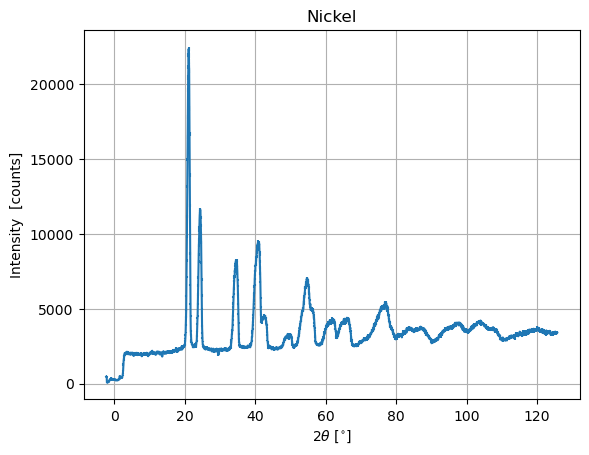

In [28]:
twotheta = calibration_curve(step,np.zeros(len(step)))[0]

#%matplotlib ipympl
plt.errorbar(twotheta,nickel_back, fmt = '-', yerr = err_nickel_back)
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel')
plt.grid()
plt.show()

Fit peak widths to Cagliolo function  
$$
FWHM(2 \theta) = \sqrt{W_0 + W_1 \tan(\theta)+ W_2 \tan(\theta)^2}
$$

In [29]:
def cagliolo_fit(x, w0,w1,w2):
    rad = x*np.pi/360
    return np.sqrt(w0+w1*np.tan(rad)+ w2*np.tan(rad)**2)

Find FWHM in $2 \theta$

In [30]:
width_nickel_peaks_new = np.array(width_nickel_peaks[0:10])
err_width_nickel_peaks_new = np.array(err_width_nickel_peaks[0:10])

half_inf = nickel_peaks_new - width_nickel_peaks_new*np.sqrt(2*np.log(2))
err_half_inf = np.sqrt(err_nickel_peaks_new**2+err_width_nickel_peaks_new**2*2*np.log(2))

half_sup = nickel_peaks_new + width_nickel_peaks_new*np.sqrt(2*np.log(2))
err_half_sup = np.sqrt(err_nickel_peaks_new**2+err_width_nickel_peaks_new**2*2*np.log(2))

inf_deg, err_inf_deg = calibration_curve(half_inf, err_half_inf)
sup_deg, err_sup_deg = calibration_curve(half_sup, err_half_sup)

fwhm = sup_deg - inf_deg
err_fwhm = np.sqrt(err_inf_deg**2+err_sup_deg**2)

print(fwhm, err_fwhm)




[0.73747203 0.87444339 1.27300938 1.76610345 1.02908439 2.25504459
 2.74033855 0.67639828 3.0746928  2.64927738] [0.18897069 0.18930474 0.19120088 0.19084004 0.19867669 0.21320138
 0.19192938 0.19480339 0.2091909  0.20476777]


 #### Fit to Cagliolo function ####
W0 1.2 +/- 0.7 deg^2
W1 -12.0 +/- 5.0 deg^2
W2 45.0 +/- 7.0 deg^2
Chi squared/ dof 0.1608596675848895


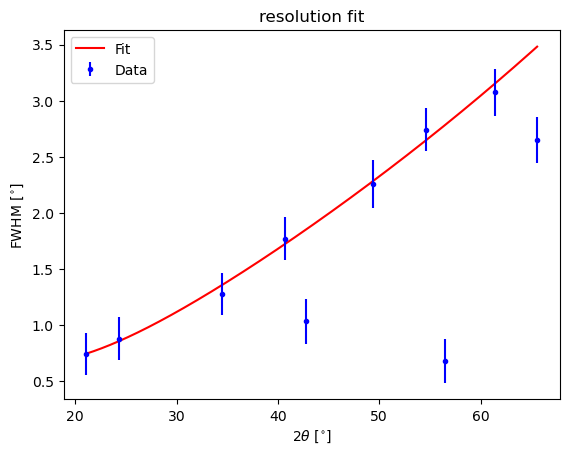

In [31]:

peaks = calibration_curve(nickel_peaks_new, err_nickel_peaks_new)[0]

fwhm_new = np.array(remove_indexes(fwhm, [4,7,9]))
err_fwhm_new = np.array(remove_indexes(err_fwhm, [4,7,9]))
peaks_new = np.array(remove_indexes(peaks, [4,7,9]))

popt, pcov = curve_fit(cagliolo_fit, peaks_new, fwhm_new, sigma= err_fwhm_new)

chi_sq = sum((cagliolo_fit(peaks_new,*popt)-fwhm_new)**2/err_fwhm_new**2)/(len(fwhm_new)-3)


print(' #### Fit to Cagliolo function ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))

print('W0',par[0][0], '+/-', par[0][1],'deg^2')
print('W1',par[1][0], '+/-', par[1][1],'deg^2')
print('W2',par[2][0], '+/-', par[2][1],'deg^2')

print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(peaks), max(peaks),10000)
plt.plot(x_plot, cagliolo_fit(x_plot, *popt),color='red')
plt.errorbar(peaks,fwhm, yerr=err_fwhm, fmt='.',color='blue')
plt.title('resolution fit')
plt.legend(['Fit', 'Data'])
plt.ylabel(r'FWHM [$^{\circ}$]')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.show()


Try to estimate TDS:  
$$
S_T(2 \theta) = 1- e^{-2 B \left(\sin \theta/\lambda\right)^2}
$$
with $2 B = 0.3559 \AA^2$


In [32]:
def tds(x, lamda,B):  # give twotheta in input in deg
    return 1- np.exp(-2*B*(np.sin(x*np.pi/360)/lamda)**2)

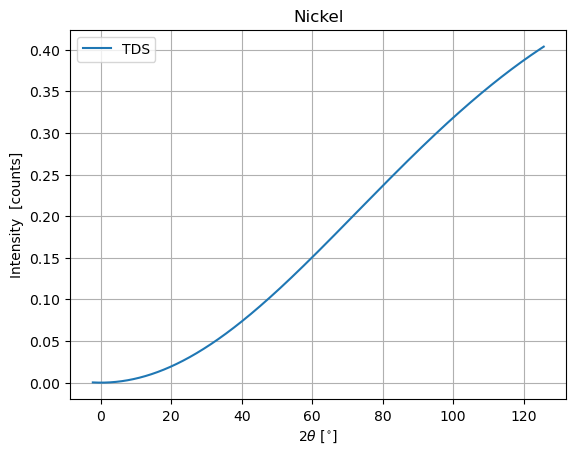

In [33]:
B = 0.3559/2 # Angstrom^2

thermal = tds(twotheta, lamda,B)

#plt.errorbar(twotheta,nickel_back, fmt = '-', yerr = err_nickel_back, label = 'Data')
plt.plot(twotheta, thermal, label = 'TDS')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [counts]')
plt.title('Nickel')
plt.legend()
plt.grid()
plt.show()

Fit the whole profile as
$$
I(2 \theta) = I_B(2 \theta) + I_T(2 \theta) + bkg
$$
with $I_B(2 \theta)$ the Bragg peaks intensity fitted before (with linear background subtraction), $I_T(2 \theta) = A S_T(2 \theta)$ and $bkg$ a constant background from incoherent scattering

In [34]:
nickel_peaks = np.array(nickel_peaks)
err_nickel_peaks = np.array(err_nickel_peaks)

width_nickel_peaks = np.array(width_nickel_peaks)
err_width_nickel_peaks = np.array(err_width_nickel_peaks)

half_inf = nickel_peaks - width_nickel_peaks/2
err_half_inf = np.sqrt(err_nickel_peaks**2+err_width_nickel_peaks**2/4)

half_sup = nickel_peaks + width_nickel_peaks/2
err_half_sup = np.sqrt(err_nickel_peaks**2+err_width_nickel_peaks**2/4)

inf_deg, err_inf_deg = calibration_curve(half_inf, err_half_inf)
sup_deg, err_sup_deg = calibration_curve(half_sup, err_half_sup)

width_deg = sup_deg - inf_deg
err_width_deg = np.sqrt(err_inf_deg**2+err_sup_deg**2)


parameters_theta = np.zeros(len(nickel_parameters))
err_parameters_theta = np.zeros(len(nickel_parameters))

for i in range(len(nickel_parameters)//3):
    parameters_theta[3*i] = nickel_parameters[3*i]
    parameters_theta[3*i+1] = calibration_curve(nickel_parameters[3*i+1], err_nickel_parameters[3*i+1])[0]
    parameters_theta[3*i+2] = width_deg[i]

    err_parameters_theta[3*i] = err_nickel_parameters[3*i]
    err_parameters_theta[3*i+1] = calibration_curve(nickel_parameters[3*i+1], err_nickel_parameters[3*i+1])[1]
    err_parameters_theta[3*i+2] = err_width_deg[i]

print(parameters_theta)

[2.03967110e+04 2.10792323e+01 3.13175534e-01 9.71818267e+03
 2.43151446e+01 3.71341916e-01 6.26136760e+03 3.44744615e+01
 5.40597309e-01 7.26200986e+03 4.06527661e+01 7.49995081e-01
 2.18211842e+03 4.28056784e+01 4.37011903e-01 7.82933030e+02
 4.93784024e+01 9.57629263e-01 4.20183511e+03 5.46097695e+01
 1.16371464e+00 1.20750177e+03 5.64799000e+01 2.87239901e-01
 1.71151796e+03 6.13931253e+01 1.30570181e+00 1.81656541e+03
 6.55750033e+01 1.12504452e+00 1.97906290e+03 7.59219103e+01
 2.09269877e+00 7.97339219e+02 7.70436458e+01 8.30057536e-01
 8.20547409e+02 8.42044138e+01 2.93283834e+00 4.22795910e+02
 8.75411721e+01 9.35800191e-01 7.38747986e+02 9.44424733e+01
 1.52290022e+00 9.66690676e+02 9.76782046e+01 1.31182615e+00
 1.08160178e+03 1.03580905e+02 2.35022584e+00 4.05069258e+02
 1.07928040e+02 8.83976208e-01 4.00221631e+02 1.19551554e+02
 3.53613270e+00]


In [35]:
def fit_full_profile_fake(x,a,b):
    global B
    global lamda
    global parameters_theta
    return gaussian_sum(x,*parameters_theta)+a*(1- np.exp(-2*B*(np.sin(x*np.pi/360)/lamda)**2)) + b


 #### Fit to full profile ####
A 2640.0 +/- 30.0 counts
bkg 2103.0 +/- 5.0 counts
Chi squared/ dof 8.906511848473507


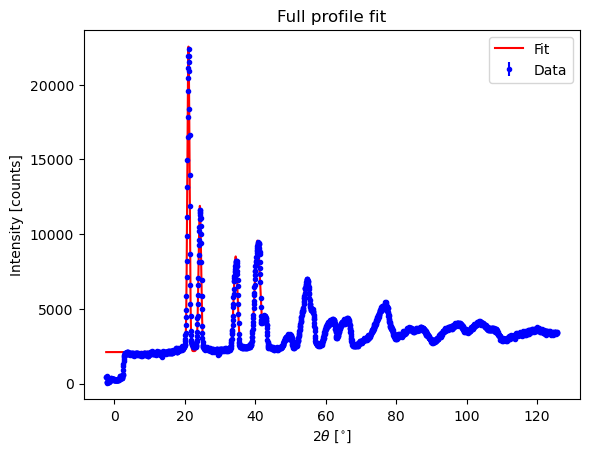

In [36]:
#%matplotlib ipympl

index = get_indices_in_range(twotheta,3,125) 
p0 = [3100,2000]
popt, pcov = curve_fit(fit_full_profile_fake, twotheta[index], nickel_back[index], sigma= err_nickel_back[index], p0=p0)

chi_sq = sum((fit_full_profile_fake(twotheta[index],*popt)-nickel_back[index])**2/err_nickel_back[index]**2)/(len(nickel_back[index])-2)


print(' #### Fit to full profile ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))

print('A',par[0][0], '+/-', par[0][1],'counts')
print('bkg',par[1][0], '+/-', par[1][1],'counts')

print('Chi squared/ dof',chi_sq)

x_plot = np.linspace(min(twotheta), max(twotheta),10000)
plt.plot(x_plot, fit_full_profile_fake(x_plot, *popt),color='red')
plt.errorbar(twotheta,nickel_back, yerr=err_nickel_back, fmt='.',color='blue')
plt.title('Full profile fit')
plt.legend(['Fit', 'Data'])
plt.ylabel(r'Intensity [counts]')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.show()

Background subtraction using $bkg + I_T(2 \theta)$

Fit parameters
bkr 2037.0 +/- 5.0 counts
TDS height 3100.0 +/- 50.0 counts


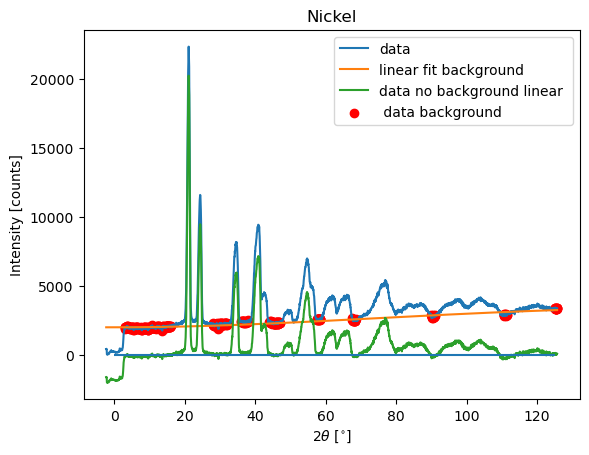

In [37]:
#background subtraction

#%matplotlib ipympl

def tds_fit(x,a,b):
    global B
    global lamda
    return a*(1- np.exp(-2*B*(np.sin(x*np.pi/360)/lamda)**2)) + b



indici = get_indices_in_range(twotheta,-3,3)
x_data_fondo = remove_indexes(list(twotheta),indici)
y_data_fondo = remove_indexes(list(nickel_back),indici)

indici = get_indices_in_range(x_data_fondo,16,28)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,32,36)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,38,44)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,47,57.5)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,58.5,67.5)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,68.5,90)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,91,110.5)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

indici = get_indices_in_range(x_data_fondo,111.4,125)
x_data_fondo = remove_indexes(list(x_data_fondo),indici)
y_data_fondo = remove_indexes(list(y_data_fondo),indici)

'''plt.plot(step,nickel_back[0],label="data")    
plt.scatter(x_data_fondo,y_data_fondo,label="background",color="red")   
plt.title("Nickel background")
plt.legend()
plt.show() '''
popt,pcov = curve_fit(tds_fit,x_data_fondo,y_data_fondo,sigma = np.sqrt(y_data_fondo))
par = my_round(popt,np.sqrt(np.diag(pcov)))
print('Fit parameters')
print('bkr',par[1][0], '+/-', par[1][1],'counts')
print('TDS height',par[0][0], '+/-', par[0][1],'counts')

plt.plot(twotheta,nickel_back,label="data")
plt.plot(twotheta,tds_fit(twotheta,*popt),label="linear fit background")
plt.plot(twotheta,nickel_back-tds_fit(twotheta,*popt),label="data no background linear ")
plt.scatter(x_data_fondo,y_data_fondo,label=" data background",color="red")  
plt.hlines(0,0,125)
plt.title("Nickel")
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity [counts]')
plt.legend()
plt.show()

nickel = nickel_back - tds_fit(twotheta, *popt)
err_nickel = np.sqrt(err_nickel_back**2 + pcov[0][0] + pcov[1][1])

# Mega fit to full profile

Fix peaks position with allowed reflections, peaks width with Caglioti function, TDS. only free parameters are peaks height, $\lambda$, $\theta_0$, $W_0$, $W_1$, $W_2$. No Sacchetti tratment as no emty cell and other ancillary measurements. Pressed powder with no cell at room temperature.

In [48]:
h = read_dat_file('nickel_vesta',1)[0]
k = read_dat_file('nickel_vesta',1)[1]
l = read_dat_file('nickel_vesta',1)[2]
d_inverso = np.sqrt(h**2+k**2+l**2)/a

intensity = read_dat_file('nickel_vesta',1)[8]*np.array([1,0.8,0.5,0.4,0.5,0.5,0.4,0.4,0.25,0.25,1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
print(max(nickel_back))

nickel_back_norm= 100*nickel_back/max(nickel_back)
err_nickel_back_norm = 100*np.sqrt(err_nickel_back**2)/max(nickel_back)

22371.666486773884


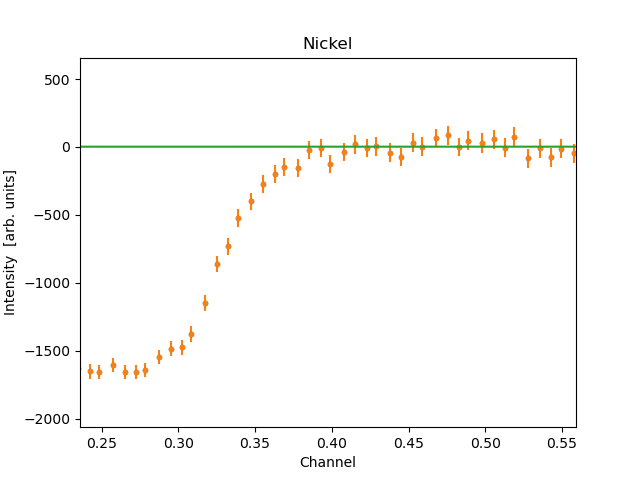

In [49]:
#%matplotlib ipympl
plt.errorbar(step,nickel_back_norm, fmt = '-', yerr = err_nickel_back_norm)
plt.xlabel('Channel')
plt.ylabel('Intensity  [arb. units]')
plt.title('Nickel')
plt.grid()
plt.show()

In [50]:
#d_inverso = d_inv[0:10]
#intensity = height_nickel_peaks[0:10]

def fit_full_profile(x,lamda,theta0,w0,w1,w2, bkg, a,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I21,I22,I23,I24,I25,I26,I27,I28,I29,I30,I31,I32,I33):

    intensita = [I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I21,I22,I23,I24,I25,I26,I27,I28,I29,I30,I31,I32,I33]
    d_theta = 0.2
    twotheta = (theta0+d_theta*x)

    tds = 1- np.exp(-2*B*(np.sin(twotheta*np.pi/360)/lamda)**2)
    peaks = np.arcsin(lamda*d_inverso/2)*360/np.pi
    widths = np.sqrt(w0+w1*np.tan(peaks*np.pi/360)+w2*np.tan(peaks*np.pi/360)**2)/(2*np.sqrt(2*np.log(2)))

    par = []

    for i in range(len(d_inverso)):
        par.append(intensita[i])
        par.append(peaks[i])
        par.append(widths[i])

    funz = bkg + a*tds + gaussian_sum(twotheta, *par)

    return funz
    

 #### Fit to full profile ####
lambda 0.7294 +/- 0.0002 Angstrom
theta0 -2.687 +/- 0.007 deg
W0 0.28 +/- 0.1 deg^2
W1 -3.5 +/- 0.8 deg^2
W2 27.0 +/- 1.0 deg^2
bkg 9.47 +/- 0.04 counts
A 9.1 +/- 0.6 counts
Intensity peak  0 90.9 +/- 0.7 counts
Intensity peak  1 43.6 +/- 0.4 counts
Intensity peak  2 27.5 +/- 0.3 counts
Intensity peak  3 32.7 +/- 0.3 counts
Intensity peak  4 8.7 +/- 0.2 counts
Intensity peak  5 4.2 +/- 0.2 counts
Intensity peak  6 13.2 +/- 0.3 counts
Intensity peak  7 11.1 +/- 0.3 counts
Intensity peak  8 8.6 +/- 0.2 counts
Intensity peak  9 0.0 +/- 700000.0 counts
Intensity peak  10 0.0 +/- 700000.0 counts
Intensity peak  11 2.4 +/- 0.2 counts
Intensity peak  12 8.5 +/- 0.3 counts
Intensity peak  13 0.0 +/- 700000.0 counts
Intensity peak  14 0.0 +/- 700000.0 counts
Intensity peak  15 2.9 +/- 0.2 counts
Intensity peak  16 2.7 +/- 0.3 counts
Intensity peak  17 2.1 +/- 0.3 counts
Intensity peak  18 0.2 +/- 0.2 counts
Intensity peak  19 0.0 +/- 900000.0 counts
Intensity peak

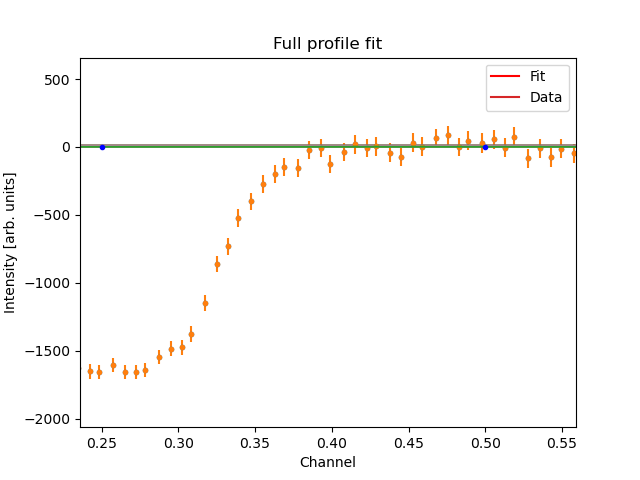

In [51]:
#%matplotlib ipympl
index = get_indices_in_range(step,27,639)#,350) 

#print(intensity)

#parameters to fit just the first 10 peaks
#p0 = [0.729,-3,1.2,-12,45,2000,2640,intensity[0],intensity[1],intensity[2],intensity[3],intensity[4],intensity[5],intensity[6],intensity[7],intensity[8],intensity[9]]
#bounds= [[0.7,-15,0,-1000,0,0,0, 0,0,0,0,0,0,0,0,0,0],[0.8,-2,100,100, 105,3000,5000, 1.5*intensity[0],1.5*intensity[1],1.5*intensity[2],1.5*intensity[3],1.5*intensity[4],1.5*intensity[5],1.5*intensity[6],1.5*intensity[7],1.5*intensity[8],1.5*intensity[9]]]

p0 = np.array([0.729,-3,1.2,-12,45,10,10])
p0 = np.append(p0,intensity)


bounds= [[0.7,-15,0,-1000,0,0,0, 0,0,0,0,0,0,0,0,0,0,  0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0 ,0,0,0,0],[0.8,-2,100,100, 105,3000,5000, 1.5*intensity[0],1.5*intensity[1],1.5*intensity[2],1.5*intensity[3],1.5*intensity[4],1.5*intensity[5],1.5*intensity[6],1.5*intensity[7],1.5*intensity[8],1.5*intensity[9], 1.5*intensity[10],1.5*intensity[11],1.5*intensity[12],1.5*intensity[13],1.5*intensity[14],1.5*intensity[15],1.5*intensity[16],1.5*intensity[17],1.5*intensity[18],1.5*intensity[19], 1.5*intensity[20],1.5*intensity[21],1.5*intensity[22],1.5*intensity[23],1.5*intensity[24],1.5*intensity[25],1.5*intensity[26],1.5*intensity[27],1.5*intensity[28],1.5*intensity[29], 1.5*intensity[30],1.5*intensity[31],1.5*intensity[32],1.5*intensity[33]]]

popt, pcov = curve_fit(fit_full_profile, step[index], nickel_back_norm[index], sigma= err_nickel_back_norm[index], p0=p0,bounds = bounds, maxfev = 80000)

chi_sq = sum((fit_full_profile(step[index],*popt)-nickel_back_norm[index])**2/err_nickel_back_norm[index]**2)/(len(nickel_back_norm[index])-(7+len(intensity)))

lamda = popt[0]
err_lamda = np.sqrt(pcov[0][0])

theta0 = popt[1]
err_theta0 = np.sqrt(pcov[1][1])

W0 = popt[2]
err_W0 = np.sqrt(pcov[2][2])

W1 = popt[3]
err_W1 = np.sqrt(pcov[3][3])

W2 = popt[4]
err_W2 = np.sqrt(pcov[4][4])

print(' #### Fit to full profile ####')
par = my_round(popt,np.sqrt(np.diag(pcov)))
#print(popt,np.sqrt(np.diag(pcov)))
gaussian_parameters = []

print('lambda',par[0][0], '+/-', par[0][1],'Angstrom')
print('theta0',par[1][0], '+/-', par[1][1],'deg')
print('W0',par[2][0], '+/-', par[2][1],'deg^2')
print('W1',par[3][0], '+/-', par[3][1],'deg^2')
print('W2',par[4][0], '+/-', par[4][1],'deg^2')
print('bkg',par[5][0], '+/-', par[5][1],'counts')
print('A',par[6][0], '+/-', par[6][1],'counts')
for i in range (len(intensity)):
    print('Intensity peak ',i ,par[7+i][0], '+/-', par[7+i][1],'counts')
    peaks = np.arcsin(popt[0]*d_inverso[i]/2)*360/np.pi
    gaussian_parameters.append(popt[7+i])
    gaussian_parameters.append(peaks)
    gaussian_parameters.append(np.sqrt(popt[2]+popt[3]*np.tan(peaks*np.pi/360)+popt[4]*np.tan(peaks*np.pi/360)**2)/(2*np.sqrt(2*np.log(2))))

print('Chi squared/ dof',chi_sq)

peaks = 360/np.pi*np.arcsin(popt[0]*d_inverso/2)
widths = np.sqrt(popt[2]+popt[3]*np.tan(peaks*np.pi/360)+popt[4]*np.tan(peaks*np.pi/360)**2)/(2*np.sqrt(2*np.log(2)))
#print(peaks)
#print(widths)
#print(intensity)

x_plot = np.linspace(min(step), max(step),10000)
plt.plot(x_plot, fit_full_profile(x_plot, *popt),color='red')
plt.errorbar(step,nickel_back_norm, yerr=err_nickel_back_norm, fmt='.',color='blue')
for i in range(len(intensity)):
    plt.plot(x_plot,gaussian(x_plot*0.2+popt[1],*gaussian_parameters[3*i : 3*i+3])+popt[5]+tds(popt[1]+0.2*x_plot,popt[0],B))
plt.title('Full profile fit')
plt.legend(['Fit', 'Data'])
plt.ylabel(r'Intensity [arb. units]')
plt.xlabel('Channel')
plt.show()



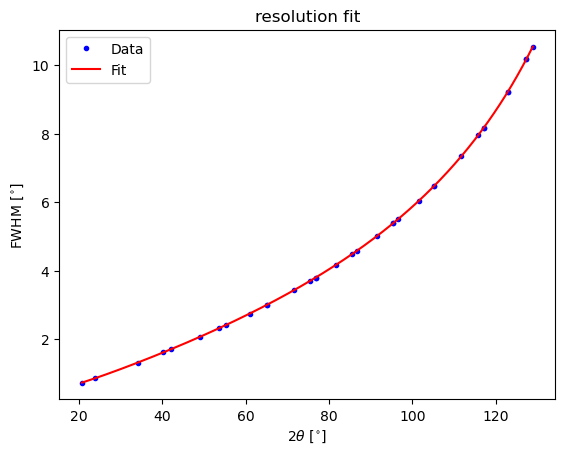

In [42]:

x_plot =  np.linspace(min(peaks), max(peaks),10000)

fit = np.sqrt(popt[2]+popt[3]*np.tan(x_plot*np.pi/360)+popt[4]*np.tan(x_plot*np.pi/360)**2)

plt.plot(peaks, 2*np.sqrt(2*np.log(2))*widths,'.',color='blue')
plt.plot(x_plot,fit,color='red')
plt.title('resolution fit')
plt.legend([ 'Data','Fit'])
plt.ylabel(r'FWHM [$^{\circ}$]')
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.show()


In [46]:
def steps_to_angle(x):
    x = np.array(x)
    return theta0 + 0.2*x, err_theta0

def steps_to_q(x):
    angle = theta0 + 0.2*x
    q = 4*np.pi*np.sin(angle*np.pi/360)/lamda   # in Angstrom inversi
    err_q = abs(q)*np.sqrt((err_lamda/lamda)**2+(err_theta0*np.pi/360/np.tan(angle*np.pi/360))**2)
    return q, err_q

#Define scattering angle 2theta and exchanged wavewector q
angle, err_angle = steps_to_angle(step)
q, err_q = steps_to_q(step)

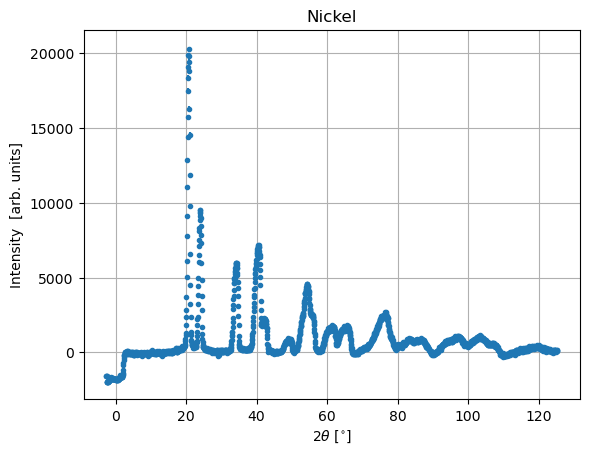

In [44]:
#%matplotlib ipympl
plt.errorbar(angle,nickel, fmt = '.', yerr = err_nickel, xerr= err_angle)
plt.xlabel(r'$2 \theta$ [$^{\circ}$]')
plt.ylabel('Intensity  [arb. units]')
plt.title('Nickel')
plt.grid()
plt.show()

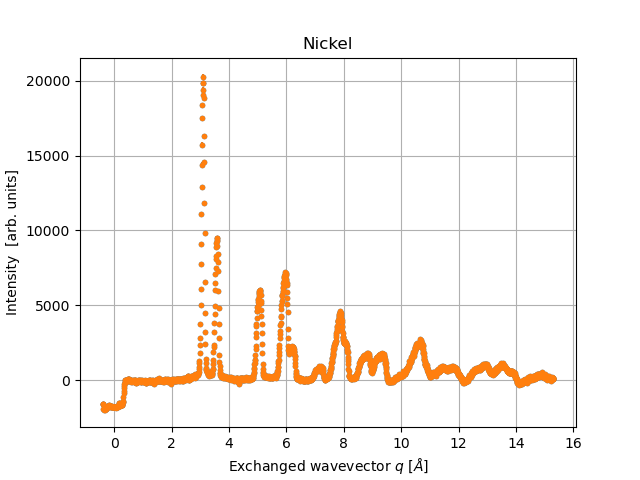

In [47]:
%matplotlib ipympl
plt.errorbar(q,nickel, fmt = '.', yerr = err_nickel, xerr= err_q)
plt.xlabel(r'Exchanged wavevector $q$ [$\AA$]')
plt.ylabel('Intensity  [arb. units]')
plt.title('Nickel')
plt.grid()
plt.show()